# Import Zone

In [166]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import geopandas as gpd

# Functions

In [203]:
def normalize_series(serie):
    # get the min and max value from the serie
    min_value = serie.min()
    max_value = serie.max()

    #Normalize the values a return the serie_normalize
    serie_normalized = (serie - min_value) / (max_value - min_value)

    return serie_normalized

def plot_series(serie, title, figwidth, figheight, bars_label = True, rotation_tick = 0):
    #Ploting zone:
    fig, ax = plt.subplots()

    #Defien x & y values for the plot
    x = serie.index
    y = serie.values

    ax.bar(x, y)
    bars = ax.bar(x, y)
    
    if bars_label == True:
        #Adding bar values
        ax.bar_label(bars) 
        
    #Adding title to th chart and font sizes
    ax.set_title(title, fontsize = 26)
    ax.tick_params(axis='x', labelsize=12, rotation = rotation_tick)
    ax.tick_params(axis='y', labelsize=12)

    # Adjusting chart size
    fig.set_figwidth(figwidth)
    fig.set_figheight(figheight)

    #Ploting the chart
    plt.show()


## Load dataset

In [168]:
df = pd.read_csv('data/Aircraft_Incident_Dataset.csv')
df_types = df.dtypes
df_shape = df.shape
print(f'The size of the dataframe is {df_shape[0]} rows and {df_shape[1]} columns.')
print('\nThe columns have the following names & types: ')
print(df_types)

The size of the dataframe is 23519 rows and 23 columns.

The columns have the following names & types: 
Incident_Date           object
Aircaft_Model           object
Aircaft_Registration    object
Aircaft_Operator        object
Aircaft_Nature          object
Incident_Category       object
Incident_Cause(es)      object
Incident_Location       object
Aircaft_Damage_Type     object
Date                    object
Time                    object
Arit                    object
Aircaft_Engines         object
Onboard_Crew            object
Onboard_Passengers      object
Onboard_Total           object
Fatalities               int64
Aircaft_First_Flight    object
Aircraft_Phase          object
Departure_Airport       object
Destination_Airport     object
Ground_Casualties       object
Collision_Casualties    object
dtype: object


In [169]:
df_passengers = pd.read_csv('data/passengers.csv', skiprows=4)
df_passengers_types = df_passengers.dtypes
df_passengers_shape = df_passengers.shape
print(f'The size of the dataframe is {df_passengers_shape[0]} rows and {df_passengers_shape[1]} columns.')
print('\nThe columns have the following names & types: ')
print(df_passengers_types)

The size of the dataframe is 266 rows and 66 columns.

The columns have the following names & types: 
Country Name       object
Country Code       object
Indicator Name     object
Indicator Code     object
1960              float64
                   ...   
2017              float64
2018              float64
2019              float64
2020              float64
Unnamed: 65       float64
Length: 66, dtype: object


## Data Segmentation

Extract only the information related with Domestic Scheduled Passenger (DSP), separating the dataframe in Incidents DSP with fatalities and DSP without fatalities:

In [170]:
df_dsp_wofatalities = df[(df["Aircaft_Nature"] == "Domestic Scheduled Passenger") & (df["Fatalities"] == 0)]
df_dsp_wofatalities_shape = df_dsp_wofatalities.shape
df_dsp_wfatalities  = df[(df["Aircaft_Nature"] == "Domestic Scheduled Passenger") & (df["Fatalities"] > 0)]
df_dsp_wfatalities_shape = df_dsp_wfatalities.shape

print(f'The number of records of Domestic Scheduled Passenger with fatalities are: {df_dsp_wfatalities_shape[0]}')
print(f'The number of records of Domestic Scheduled Passenger without fatalities are: {df_dsp_wofatalities_shape[0]}')

The number of records of Domestic Scheduled Passenger with fatalities are: 1755
The number of records of Domestic Scheduled Passenger without fatalities are: 2249


# Causes

## Determine the most common reason/cause of airplane crashes and their fatality rate?

### What are the categories of cause most common in accidents with fatalities?

In [171]:
#Extract just the data related with incident cause (Column 7) when the accidents have fatalities and Separate each value by "," Character, due to each value has multiple causes, For example: Airplane - Engines, Airplane - Engines - Fire, Cargo - Overloaded
all_causes_wfatalities_separated = df_dsp_wfatalities['Incident_Cause(es)'].apply(lambda x: x.split(","))

#Iterate each flight to get just the first word of each cause, for example : Airplane - Engines -> Airplane and eliminating the duplicates in each element.
all_causes_wfatalities_separated_unique = all_causes_wfatalities_separated.apply(lambda x: list(set([elem.split('-')[0].strip() for elem in x])))

#Transform the set in a flat list with all the causes
flat_list_all_causes_wfatalities = [word for series in all_causes_wfatalities_separated_unique for word in series]

#Count the frecuency of each cause and delete word mountain due to it is not a category and take just the top 5 values
series_all_causes_wfatalities_frecuency = pd.Series(flat_list_all_causes_wfatalities).value_counts().drop('mountain')[:5]
series_all_causes_wfatalities_frecuency



Result      1281
Info         369
Airplane     224
Weather      164
Security     137
dtype: int64

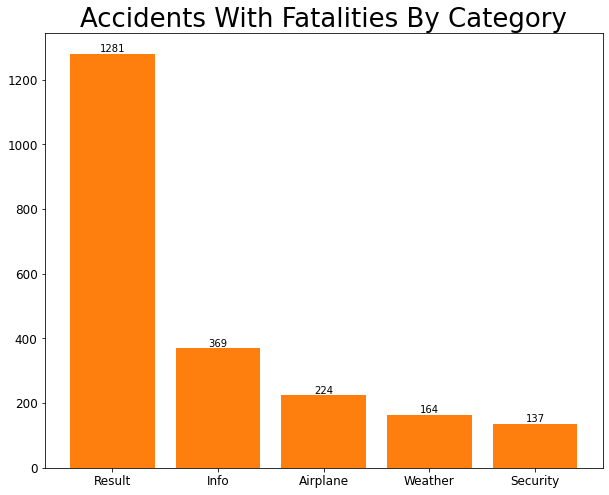

In [204]:
plot_series(series_all_causes_wfatalities_frecuency, 'Accidents With Fatalities By Category', 10, 8)

### What happen with these categories in accidents without fatalities?

In [173]:
#Extract just the data related with incident cause (Column 7) when the accidents have fatalities and Separate each value by "," Character, due to each value has multiple causes, For example: Airplane - Engines, Airplane - Engines - Fire, Cargo - Overloaded
all_causes_wofatalities_separated = df_dsp_wofatalities['Incident_Cause(es)'].apply(lambda x: x.split(","))

#Iterate each flight to get just the first word of each cause, for example : Airplane - Engines -> Airplane and eliminating the duplicates in each element.
all_causes_wofatalities_separated_unique = all_causes_wofatalities_separated.apply(lambda x: list(set([elem.split('-')[0].strip() for elem in x])))

#Transform the set in a flat list with all the causes
flat_list_all_causes_wofatalities = [word for series in all_causes_wofatalities_separated_unique for word in series]

#Count the frecuency of each cause and delete word mountain due to it is not a category and take just the top 5 values
series_all_causes_wofatalities_frecuency = pd.Series(flat_list_all_causes_wofatalities).value_counts().drop('mountain')
series_all_causes_wofatalities_frecuency = series_all_causes_wofatalities_frecuency.loc[['Result', 'Info', 'Airplane', 'Weather', 'Security']]
series_all_causes_wofatalities_frecuency

Result      1756
Info         238
Airplane     321
Weather       73
Security     678
dtype: int64

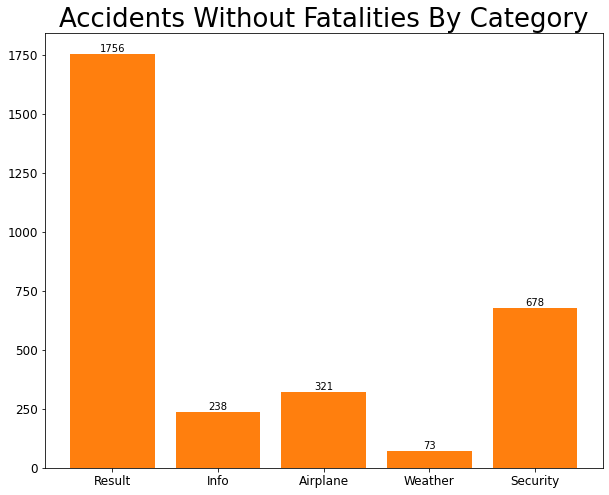

In [174]:
plot_series(series_all_causes_wofatalities_frecuency, 'Accidents Without Fatalities By Category', 10, 8)

### Comparison between accidents with/without fatalities

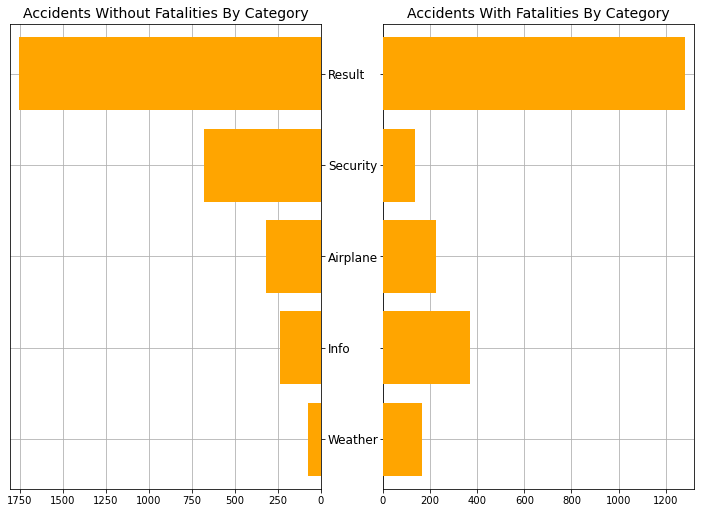

In [175]:
# Data
causes = series_all_causes_wfatalities_frecuency.index

wofatalities = series_all_causes_wofatalities_frecuency.values

wfatalities = series_all_causes_wfatalities_frecuency.values

# Sort by number of wfatalities wofatalities
idx = wofatalities.argsort()
causes, wofatalities, wfatalities = [np.take(x, idx) for x in [causes, wofatalities, wfatalities]]

y = np.arange(wfatalities.size)

# Prepare bars alignment
fig, ax = plt.subplots(ncols=2, sharey=True)

ax[0].barh(y, wofatalities, align='center', color='orange', zorder=10)
ax[1].barh(y, wfatalities, align='center', color='orange', zorder=10)

ax[0].set_title('Accidents Without Fatalities By Category', fontsize = 14)
ax[1].set_title('Accidents With Fatalities By Category', fontsize = 14)
ax[0].invert_xaxis()
ax[0].set(yticks=y, yticklabels=causes)
ax[0].tick_params(axis='y', labelsize=12)
ax[0].yaxis.tick_right()

for ax in ax.flat:
    ax.margins(0.03)
    ax.grid(True)

fig.tight_layout()
fig.subplots_adjust(wspace=0.2)

# Adjusting chart size
fig.set_figwidth(10)
fig.set_figheight(8)

plt.show()

### What are the subcategories inside "Result" most common in accidents with fatalities?

In [176]:
#Get the data with fatalities
all_causes_wfatalities_separated = df_dsp_wfatalities['Incident_Cause(es)'].apply(lambda x: x.split(","))
#Get just the accident causes that contains the word "Result"
only_result_category_wfatalities = all_causes_wfatalities_separated.apply(lambda lista: [item for item in lista if 'Result' in item])
#Get the subcategory inside result
sub_result_categories_wfatalities = only_result_category_wfatalities.apply(lambda x: list([elem.split('-')[1] for elem in x]))
#Transform the set in a flat list with all the causes
sub_result_categories_flat_wfatalities = [word for series in sub_result_categories_wfatalities for word in series]
#Count the frecuency of each subcategory
sub_result_categories_frecuency_wfatalities = pd.Series(sub_result_categories_flat_wfatalities).value_counts()[:5]
sub_result_categories_frecuency_wfatalities

 CFIT                493
 Loss of control     482
 Emergency           103
 Runway excursion     88
 Hijacking            64
dtype: int64

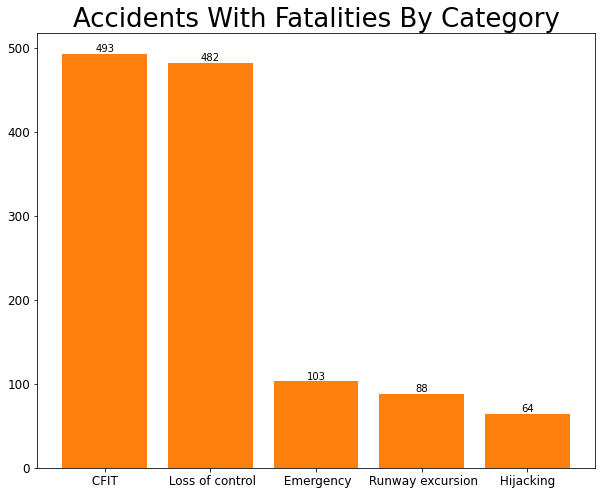

In [177]:
plot_series(sub_result_categories_frecuency_wfatalities, 'Accidents With Fatalities By Category', 10, 8)

### What is the subcategories inside "Result" most common in accidents without fatalities?

In [178]:
#Get the data with fatalities
all_causes_wofatalities_separated = df_dsp_wofatalities['Incident_Cause(es)'].apply(lambda x: x.split(","))
#Get just the accident causes that contains the word "Result"
only_result_category_wofatalities = all_causes_wofatalities_separated.apply(lambda lista: [item for item in lista if 'Result' in item])
#Get the subcategory inside result
sub_result_categories_wofatalities = only_result_category_wofatalities.apply(lambda x: list([elem.split('-')[1] for elem in x]))
#Transform the set in a flat list with all the causes
sub_result_categories_flat_wofatalities = [word for series in sub_result_categories_wofatalities for word in series]
#Count the frecuency of each subcategory
sub_result_categories_frecuency_wofatalities = pd.Series(sub_result_categories_flat_wofatalities).value_counts()[:5]
sub_result_categories_frecuency_wofatalities

 Hijacking                508
 Runway excursion         435
 Runway mishap            308
 Emergency                219
 Damaged on the ground    156
dtype: int64

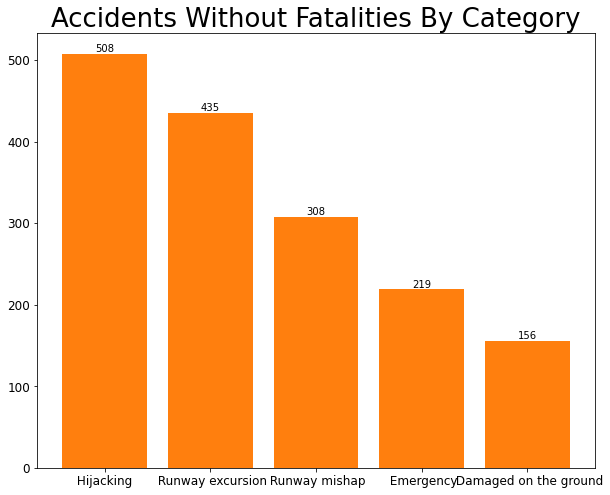

In [179]:
plot_series(sub_result_categories_frecuency_wofatalities, 'Accidents Without Fatalities By Category', 10, 8)

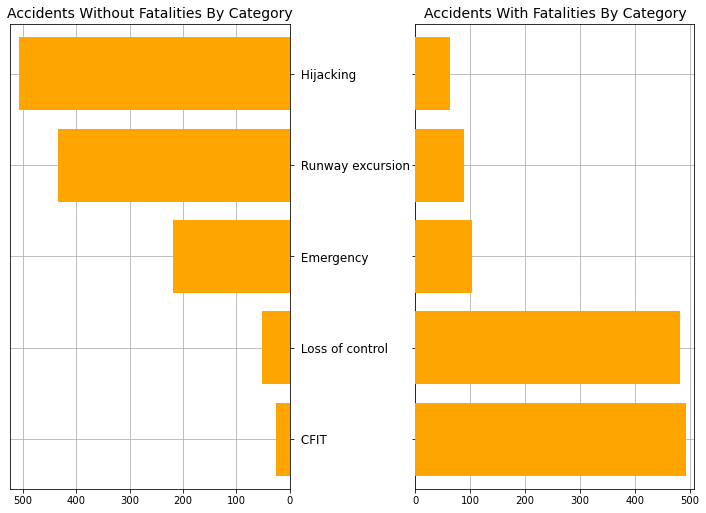

In [180]:
# Data
causes = sub_result_categories_frecuency_wfatalities.index

wofatalities = pd.Series(sub_result_categories_flat_wofatalities).value_counts()[causes].values

wfatalities = sub_result_categories_frecuency_wfatalities.values

# Sort by number of wfatalities wofatalities
idx = wofatalities.argsort()
causes, wofatalities, wfatalities = [np.take(x, idx) for x in [causes, wofatalities, wfatalities]]

y = np.arange(wfatalities.size)

# Prepare bars alignment
fig, ax = plt.subplots(ncols=2, sharey=True)

ax[0].barh(y, wofatalities, align='center', color='orange', zorder=10)
ax[1].barh(y, wfatalities, align='center', color='orange', zorder=10)

ax[0].set_title('Accidents Without Fatalities By Category', fontsize = 14)
ax[1].set_title('Accidents With Fatalities By Category', fontsize = 14)
ax[0].invert_xaxis()
ax[0].set(yticks=y, yticklabels=causes)
ax[0].tick_params(axis='y', labelsize=12)
ax[0].yaxis.tick_right()

for ax in ax.flat:
    ax.margins(0.03)
    ax.grid(True)

fig.tight_layout()
fig.subplots_adjust(wspace=0.45)

# Adjusting chart size
fig.set_figwidth(10)
fig.set_figheight(8)

plt.show()

# Ocurrences

## Determine what airlines/brand have most commonly been involved in accidents and over what geographical regions?

### What is the brand involved in more accidents without accidents?

In [181]:
#Extract the values of the column 2 (Aircraft models)
aicraft_models_wofatalities = df_dsp_wofatalities['Aircaft_Model']
#Split the string in the coloumn to select just the first word of the aircraft model, the first word is the brand of the model) and count how many times appears each brand in the column.
count_aicraft_models_wofatalities = aicraft_models_wofatalities.apply(lambda x: x.split(" ")[0]).value_counts()[:10]
count_aicraft_models_wofatalities

Boeing       498
Douglas      180
McDonnell    176
de           134
Fokker       108
Airbus       100
Antonov       89
Tupolev       72
Embraer       61
ATR           57
Name: Aircaft_Model, dtype: int64

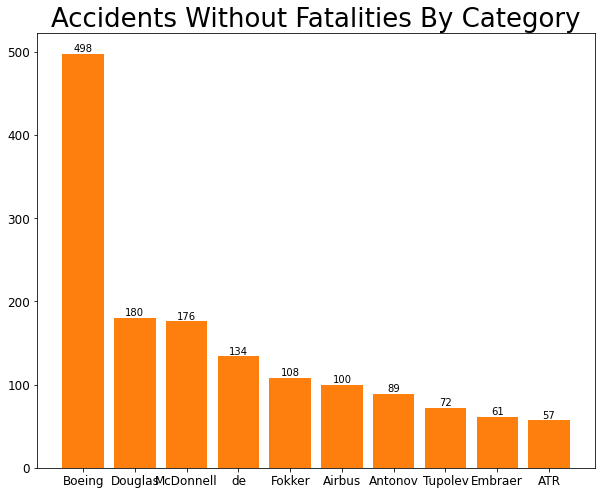

In [182]:
plot_series(count_aicraft_models_wofatalities, 'Accidents Without Fatalities By Category', 10, 8)

### What is the brand involved in more accidents with accidents?

In [183]:
#Extract the values of the column 2 (Aircraft models)
aicraft_models_wfatalities = df_dsp_wfatalities['Aircaft_Model']
#Split the string in the coloumn to select just the first word of the aircraft model, the first word is the brand of the model) and count how many times appears each brand in the column.
count_aicraft_models_wfatalities = aicraft_models_wfatalities.apply(lambda x: x.split(" ")[0]).value_counts()[:10]
count_aicraft_models_wfatalities

Douglas      399
Boeing       137
de           113
Antonov      111
Ilyushin      83
Fokker        82
Tupolev       70
Lockheed      60
Lisunov       54
McDonnell     51
Name: Aircaft_Model, dtype: int64

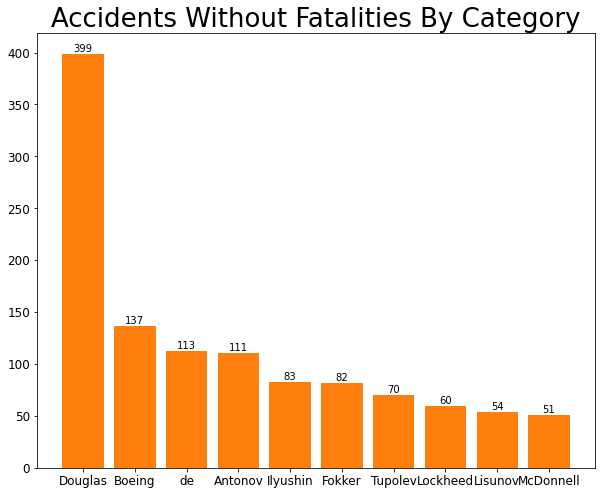

In [184]:
plot_series(count_aicraft_models_wfatalities, 'Accidents Without Fatalities By Category', 10, 8)

### What is the Airline involved in more accidents (withFatalities)?

In [185]:
#Extract the values of the column 4 (Aircraft_Operator)
raw_aircraftoperators_wfatalities = df_dsp_wfatalities['Aircaft_Operator']
#Remove all op . for and get just the aeroline in charge, For instance : AeroPerlas op . for SANSA -> SANSA
aircraftoperators_wfatalities = raw_aircraftoperators_wfatalities.str.replace(r'op\.for', lambda x: x.split("op.for")[-1])
aircraftoperators_wfatalities = aircraftoperators_wfatalities.str.replace(r'opf', lambda x: x.split("opf")[-1])
aircraftoperators_wfatalities = aircraftoperators_wfatalities.str.replace(r'opb', lambda x: x.split("opb")[-1])
#Combine all Aeroplot variants, For instance : Aeroflot Moscow -> Aeroflot
aircraftoperators_wfatalities = aircraftoperators_wfatalities.str.replace(r'Aeroflot.*', 'Aeroflot')
aircraftoperators_wfatalities = aircraftoperators_wfatalities.value_counts()[:5]
aircraftoperators_wfatalities


C:\Users\CAMILO~1\AppData\Local\Temp/ipykernel_21408/2716473731.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  aircraftoperators_wfatalities = raw_aircraftoperators_wfatalities.str.replace(r'op\.for', lambda x: x.split("op.for")[-1])
C:\Users\CAMILO~1\AppData\Local\Temp/ipykernel_21408/2716473731.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  aircraftoperators_wfatalities = aircraftoperators_wfatalities.str.replace(r'Aeroflot.*', 'Aeroflot')


Aeroflot                282
United Airlines          33
Philippine Air Lines     28
Eastern Air Lines        25
American Airlines        25
Name: Aircaft_Operator, dtype: int64

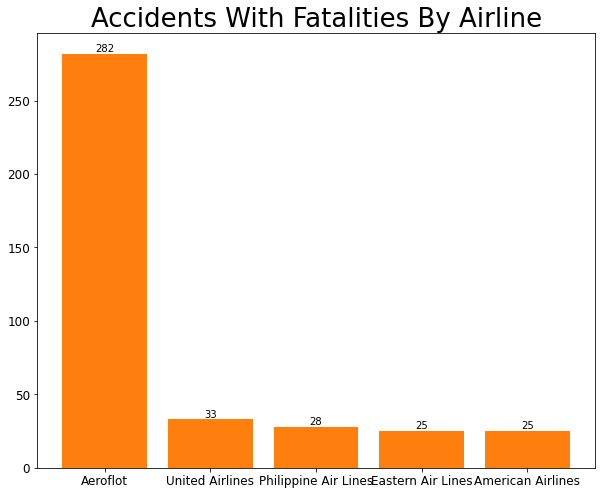

In [186]:
plot_series(aircraftoperators_wfatalities, 'Accidents With Fatalities By Airline', 10, 8)

### What is the Airline involved in more accidents (withoutFatalities)?

In [187]:
#Extract the values of the column 4 (Aircraft_Operator)
raw_aircraftoperators_wofatalities = df_dsp_wofatalities['Aircaft_Operator']
#Remove all op . for and get just the aeroline in charge, For instance : AeroPerlas op . for SANSA -> SANSA
aircraftoperators_wofatalities = raw_aircraftoperators_wofatalities.str.replace(r'op\.for', lambda x: x.split("op.for")[-1])
aircraftoperators_wofatalities = aircraftoperators_wofatalities.str.replace(r'opf', lambda x: x.split("opf")[-1])
aircraftoperators_wofatalities = aircraftoperators_wofatalities.str.replace(r'opb', lambda x: x.split("opb")[-1])
#Combine all Aeroplot variants, For instance : Aeroflot Moscow -> Aeroflot
aircraftoperators_wofatalities = aircraftoperators_wofatalities.str.replace(r'Aeroflot.*', 'Aeroflot')
aircraftoperators_wofatalities = aircraftoperators_wofatalities.value_counts()[:5]
aircraftoperators_wofatalities

C:\Users\CAMILO~1\AppData\Local\Temp/ipykernel_21408/2348874873.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  aircraftoperators_wofatalities = raw_aircraftoperators_wofatalities.str.replace(r'op\.for', lambda x: x.split("op.for")[-1])
C:\Users\CAMILO~1\AppData\Local\Temp/ipykernel_21408/2348874873.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  aircraftoperators_wofatalities = aircraftoperators_wofatalities.str.replace(r'Aeroflot.*', 'Aeroflot')


Aeroflot             157
Eastern Air Lines     68
Indian Airlines       58
American Airlines     56
Delta Air Lines       52
Name: Aircaft_Operator, dtype: int64

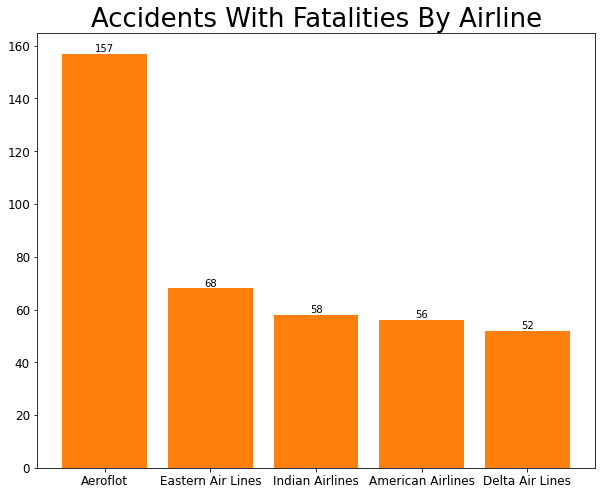

In [188]:
plot_series(aircraftoperators_wofatalities, 'Accidents With Fatalities By Airline', 10, 8)

### Where is the most dangerous place to take a fly  (withFatalities)?

In [189]:
#Extract the information in the column 20 (Departure Airport)
departure_airport_data_wfatalities = df_dsp_wfatalities['Departure_Airport']
#Extract the last word of the data in the column, the last word is the country where the plane start the travel.
countries_data_wfatalities = departure_airport_data_wfatalities.apply(lambda x: x.split(",")[-1].strip())
#Eliminate the cases where the country is unknown ("?")
countries_data_wfatalities = countries_data_wfatalities[countries_data_wfatalities != "?"]
#Count how many times appear each country
countries_data_wfatalities = countries_data_wfatalities.value_counts()
countries_data_wfatalities


United States of America    314
Russia                      223
Brazil                      101
Colombia                     80
Indonesia                    58
                           ... 
Comoros                       1
Guadeloupe                    1
Uruguay                       1
Djibouti                      1
Hong Kong                     1
Name: Departure_Airport, Length: 132, dtype: int64

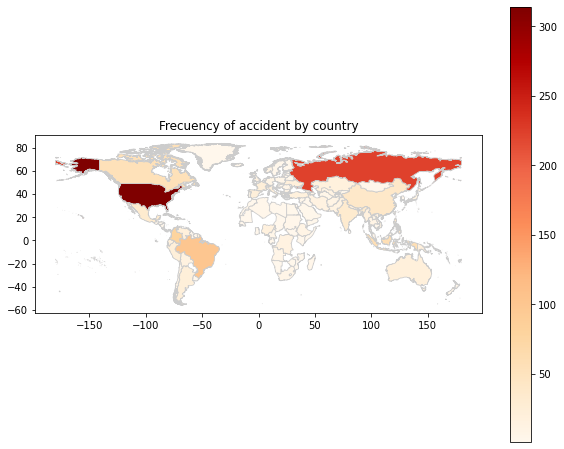

In [190]:
#Charge the geospatial data of the countries,
#From: https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-countries/
world = gpd.read_file("data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp")

#Convert my series to a df
frecuency = countries_data_wfatalities.to_frame(name='frecuency')

#Add as the index the name of the country
frecuency.reset_index(inplace=True)
frecuency.rename(columns={'index': 'ADMIN'}, inplace=True)

#Unir los datos geoespaciales con el DataFrame de frecuencias por el nombre del país
#Merge the frecuency with the geospacial data
world_with_frequencies = world.merge(frecuency, on='ADMIN')

#Create the plot
fig, ax = plt.subplots(figsize=(10, 8))
world_with_frequencies.plot(column='frecuency', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
plt.title("Frecuency of accident by country")
plt.show()

# Insights

## Determine if air transportation has become safer over time

###  Determine the number of Fatalities per year

In [191]:
#Extract the information of the column 1 and 17 (Date, Fatalities)
fatalities_per_year = df_dsp_wfatalities[['Incident_Date', 'Fatalities']]
#Take just the year form de date
fatalities_per_year['Incident_Date'] = fatalities_per_year['Incident_Date'].apply(lambda x: x.split("-")[-1])
#Sort and count the fatalities per year
fatalities_per_year = fatalities_per_year.sort_values(by='Incident_Date')
fatalities_per_year_grouped = fatalities_per_year.groupby('Incident_Date')['Fatalities'].sum()
fatalities_per_year_grouped

C:\Users\CAMILO~1\AppData\Local\Temp/ipykernel_21408/242133669.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fatalities_per_year['Incident_Date'] = fatalities_per_year['Incident_Date'].apply(lambda x: x.split("-")[-1])


Incident_Date
1928      3
1929     17
1930     13
1931     15
1932      7
       ... 
2017     12
2018    455
2019     86
2020    101
2021     94
Name: Fatalities, Length: 94, dtype: int64

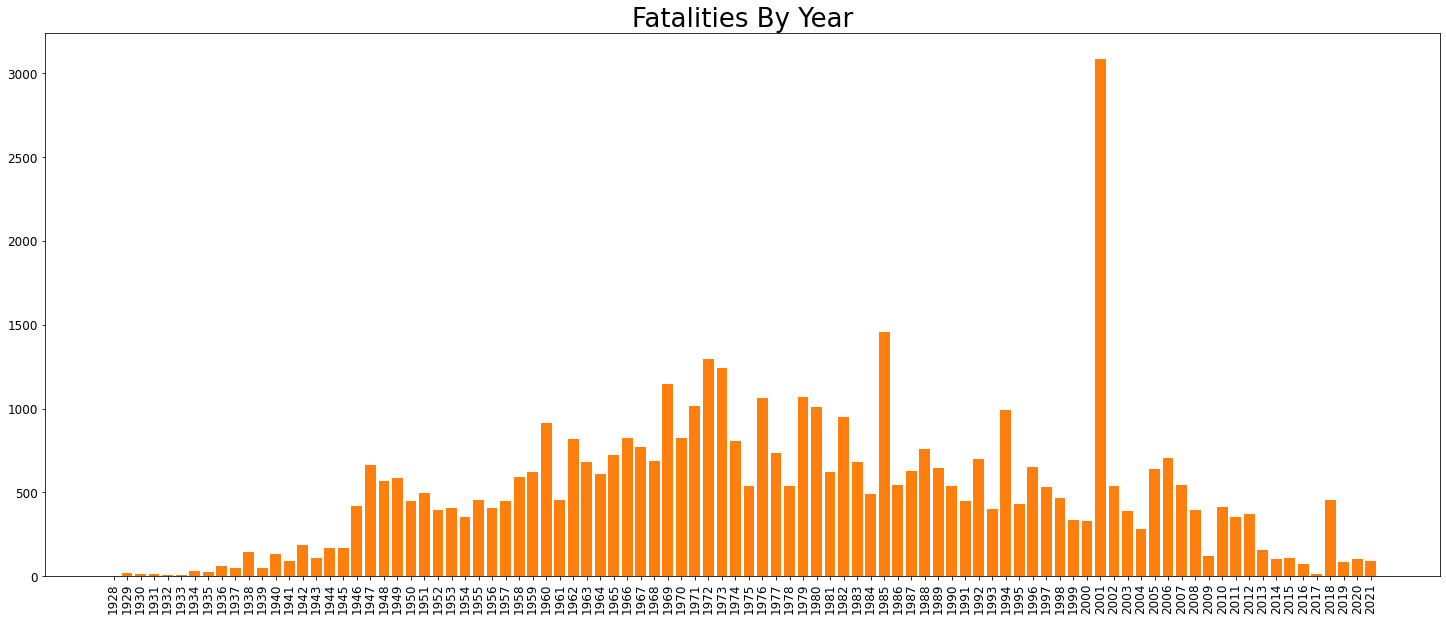

In [205]:
plot_series(fatalities_per_year_grouped, 'Fatalities By Year', 25, 10, False, 90)

###  Determine the number of accidents per year

In [193]:
#Extract the information of the column 1 Date
accidents_per_year = df_dsp_wfatalities['Incident_Date']
#Count how many accidents happen by year
accidents_per_year = accidents_per_year.apply(lambda x: x.split("-")[-1])
accidents_per_year = accidents_per_year.value_counts().sort_index()
accidents_per_year

1928    1
1929    4
1930    2
1931    3
1932    1
       ..
2017    4
2018    8
2019    7
2020    2
2021    3
Name: Incident_Date, Length: 94, dtype: int64

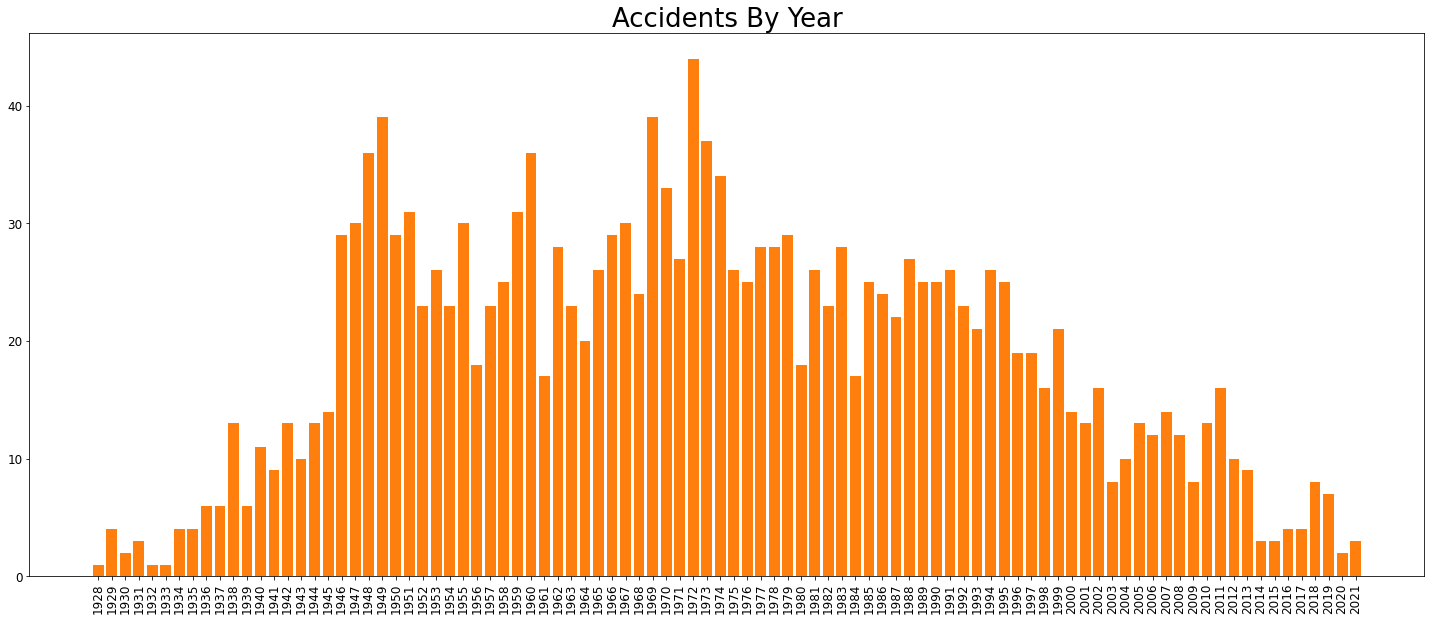

In [206]:
plot_series(accidents_per_year, 'Accidents By Year', 25, 10, False, 90)

### Compare passengers, fatalities, accidents per year

In [195]:
#Logic to adapt passengers dataframe to the fatalities/accidients dataframe. 
df_passengers_transpose = df_passengers.transpose()
df_passengers_transpose = df_passengers_transpose.iloc[5:]
df_passengers_transpose['Passengers'] = df_passengers_transpose.sum(axis=1)
indexes_to_delete = list(range(len(df_passengers_transpose.columns) - 1))
df_passengers_transpose.drop(df_passengers_transpose.columns[indexes_to_delete], axis=1, inplace=True)

In [196]:
#Normalize the 3 series to compare them in the same plot
accidents_per_year_normalize = normalize_series(accidents_per_year)
fatalities_per_year_grouped_normalize = normalize_series(fatalities_per_year_grouped)
df_passengers_transpose_normalize = normalize_series(df_passengers_transpose)[:-1]

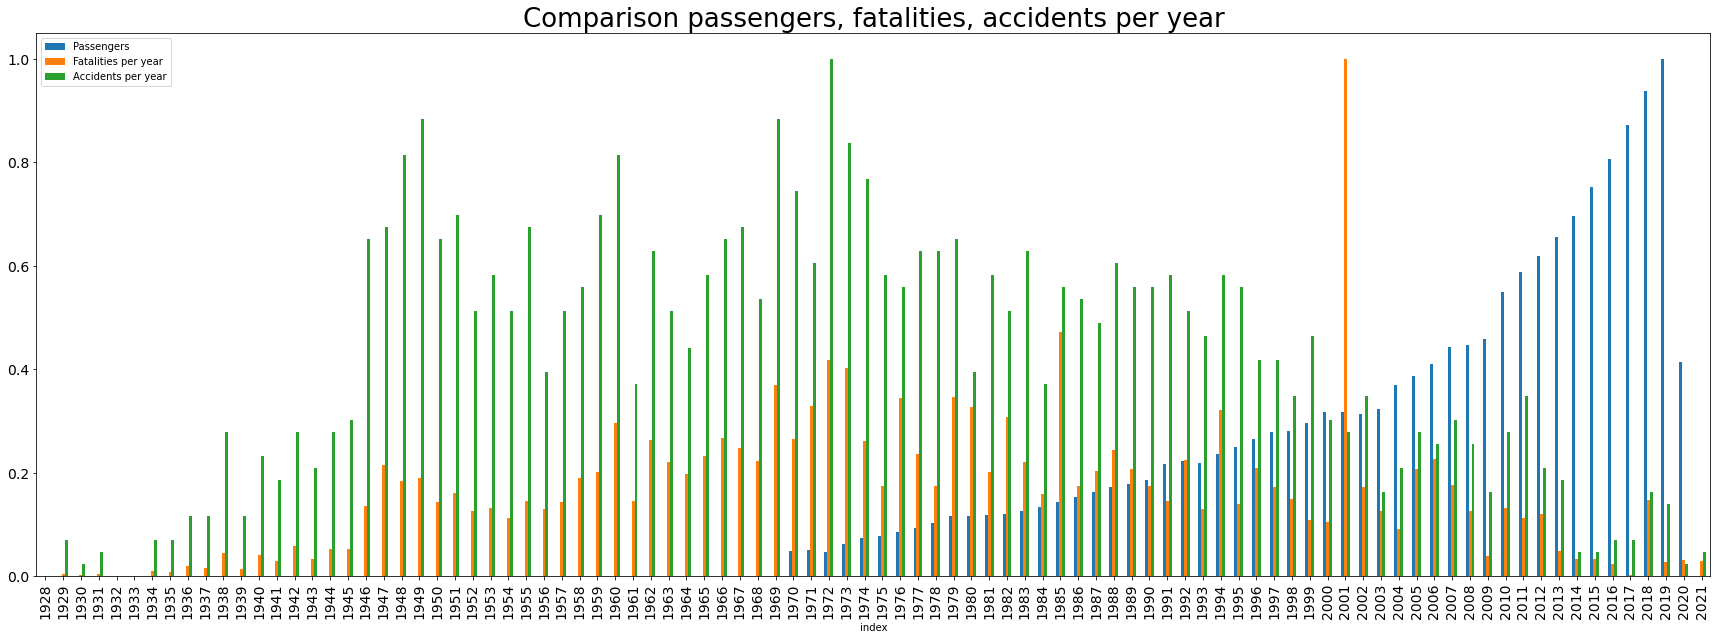

In [211]:
#Plot the comparison
df_accidents_fatalities_passengers = pd.concat([df_passengers_transpose_normalize, fatalities_per_year_grouped_normalize, accidents_per_year_normalize], axis=1)
df_accidents_fatalities_passengers.columns = ['Passengers', 'Fatalities per year', 'Accidents per year']
df_accidents_fatalities_passengers.reset_index(inplace=True)
df_accidents_fatalities_passengers = df_accidents_fatalities_passengers.sort_values(by='index')

fig, ax = plt.subplots(figsize=(30, 10))

df_accidents_fatalities_passengers.plot(x='index', kind='bar', ax=ax)

ax.set_title('Comparison passengers, fatalities, accidents per year', fontsize = 26)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)

plt.show()